In [1]:
import scarches as sca
import scanpy as sc
import matplotlib as mpl
import scipy.sparse
import numpy as np
import pandas as pd
import os

Using TensorFlow backend.


In [2]:
mpl.rcParams["figure.figsize"] = (12, 12)

## Load Habermann data

Save it as h5ad, much faster loading

Original 10x matrix from here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4037322

Manual modifications of `genes.tsv.gz` are needed: add 2 columns, 1 dummy, 1 `Gene Expression` to make it look like 10x feature file. And rename to `features.tsv.gz`

In [3]:
if os.path.exists("../data/03ipf_projection/habermann.h5ad"):
    ds = sc.read_h5ad("../data/03ipf_projection/habermann.h5ad")
else:
    ds = sc.read_10x_mtx("../data/03ipf_projection/", var_names="gene_ids")
    ds.write_h5ad("../data/03ipf_projection/habermann.h5ad")

In [4]:
ds

AnnData object with n_obs × n_vars = 220213 × 33694
    var: 'gene_symbols', 'feature_types'

Load metadata

In [5]:
meta = pd.read_csv("../data/03ipf_projection/IPF_metadata.csv", index_col=0)

In [6]:
meta

,orig.ident,nCount_RNA,nFeature_RNA,Diagnosis,Sample_Name,Sample_Source,Status,percent.mt,nCount_SCT,nFeature_SCT,seurat_clusters,population,celltype
F00431_AGAGCTTGTAGAGGAA,F00431,15703,4231,IPF,TILD001,NTI,Disease,5.483029,8331,3526,8,Epithelial,MUC5AC+ High
F01380_GATCTAGTCTTGCCGT,F01380,18128,3411,IPF,TILD028,NTI,Disease,4.082083,7728,2333,20,Epithelial,MUC5AC+ High
F01391_AGTCTTTAGGTTACCT,F01391,41380,6802,IPF,VUILD65,Vanderbilt,Disease,3.339778,7891,3155,20,Epithelial,MUC5AC+ High
F01391_ATCCACCAGGAGTCTG,F01391,37524,5003,IPF,VUILD65,Vanderbilt,Disease,3.528408,8067,1728,20,Epithelial,MUC5AC+ High
F01391_CTCGTCATCATCTGCC,F01391,17885,4341,IPF,VUILD65,Vanderbilt,Disease,5.065698,7863,3249,20,Epithelial,MUC5AC+ High
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ILD62-2_ACGAGGATCTGCCAGG,ILD62-2,3296,1768,NSIP,VUILD62,Vanderbilt,Disease,6.401699,5425,1809,3,Mesenchymal,Smooth Muscle Cells
ILD63_AACTCTTCAGACTCGC,ILD63,3661,1756,IPF,VUILD63,Vanderbilt,Disease,7.183830,5385,1784,3,Mesenchymal,Smooth Muscle Cells
ILD63_CAGAATCTCCACGTTC,ILD63,1951,1075,IPF,VUILD63,Vanderbilt,Disease,7.739621,5162,1339,2,Mesenchymal,Smooth Muscle Cells
ILD63_CTGAAACAGAAGGTGA,ILD63,2978,1603,IPF,VUILD63,Vanderbilt,Disease,5.977166,5398,1661,3,Mesenchymal,Smooth Muscle Cells


Remove cells not in metadata (50% O_o)

In [7]:
ds = ds[ds.obs_names.isin(meta.index), :]
ds

View of AnnData object with n_obs × n_vars = 114396 × 33694
    var: 'gene_symbols', 'feature_types'

Set metadata to AnnData object

In [8]:
ds.obs = meta.loc[ds.obs_names, :]

In [9]:
condition_key = "Study"

Set the study key

In [10]:
ds.obs["Study"] = "Habermann_et_al_2020"
ds.obs.Study = ds.obs.Study.astype("category")

In [11]:
sc.pp.normalize_total(ds, target_sum=1e4)

In [12]:
sc.pp.log1p(ds)

In [13]:
ds.obs["orig.ident"] = ds.obs["orig.ident"].astype("category")

In [14]:
sc.pp.highly_variable_genes(ds, n_top_genes=4000, batch_key="orig.ident")

... storing 'Diagnosis' as categorical
... storing 'Sample_Name' as categorical
... storing 'Sample_Source' as categorical
... storing 'Status' as categorical
... storing 'population' as categorical
... storing 'celltype' as categorical


In [15]:
adata = ds[:, ds.var.highly_variable]

## Train scArches

Now with random seed!

In [16]:
network = sca.models.scArches(task_name='habermann_ref',
                              x_dimension=adata.shape[1],
                              z_dimension=10,
                              architecture=[128, 128],
                              gene_names=adata.var_names.tolist(),
                              conditions=adata.obs[condition_key].unique().tolist(),
                              alpha=0.001,
                              loss_fn='sse',
                              model_path="./models/scArches/",
                              seed=1066)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

scArches' network has been successfully constructed!




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scArches' network has been successfully compiled!


In [17]:
network.train(adata,
              condition_key=condition_key,
              n_epochs=200,
              batch_size=128,
              save=True,
              retrain=False)



scArches' network has been successfully compiled!
cvae's weights has been successfully restored!


## Explore latent space of the reference

In [23]:
latent_adata = network.get_latent(adata, condition_key)

In [30]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

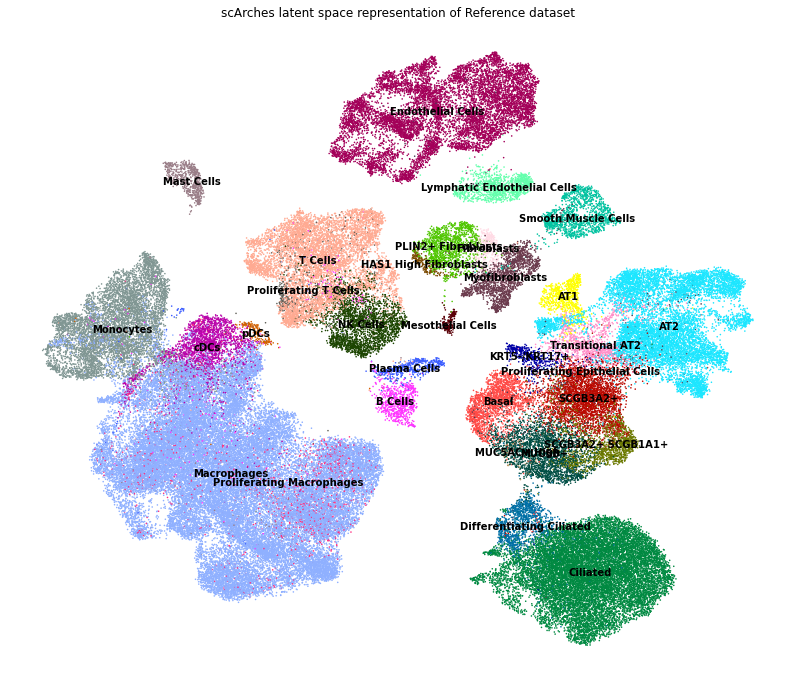

In [31]:
sc.pl.umap(latent_adata, color="celltype",
           frameon=False, legend_loc="on data", size=10, 
           title="scArches latent space representation of Reference dataset")

Looks good, most annotated cell types are clustered separately, largely recapitulating the original figure. Moving on…

## Load Bharat dataset

In [76]:
query = sc.read_h5ad("../data/02dataset/20global.h5ad")

In [33]:
query = query.raw.to_adata()

In [34]:
query.obs["Study"] = "Bharat_et_al_2020"
query.obs.Study = query.obs.Study.astype("category")

Check variable genes' compatibility with Habermann.

As a side note to myself: we can combine Habermann and Query data beforehand, identify common HVGs and use them for training

In [35]:
query.var_names.isin(adata.var_names).sum()

3699

In [36]:
query = query[:, query.var_names.isin(adata.var_names)]

In [37]:
query.shape

(155413, 3699)

Add missing genes as zeroes

In [38]:
missing_genes = adata.var_names[~adata.var_names.isin(query.var_names)]

In [39]:
zeros = np.zeros(shape=(query.shape[0], missing_genes.size))
missing_genes_expr = scipy.sparse.csc_matrix(zeros, shape=(query.shape[0], missing_genes.size))

In [40]:
new_X = scipy.sparse.hstack([query.X, missing_genes_expr])

In [41]:
new_var = query.var.copy()

In [42]:
new_var = new_var.reindex(np.hstack([new_var.index, missing_genes]))

In [43]:
query = sc.AnnData(new_X.tocsc(), obs=query.obs, var=new_var)

In [44]:
query.shape

(155413, 4000)

## Project query on reference

In [45]:
new_network = sca.operate(network,
                          new_task_name="bharat_query",
                          new_conditions=[query.obs.Study.values[0]])

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


In [46]:
new_network.train(query,
                  train_size=0.8,
                  condition_key=condition_key,
                  n_epochs=50,
                  batch_size=512, 
                  save=True,
                  retrain=False)

scArches' network has been successfully compiled!
cvae's weights has been successfully restored!


## Explore latent space of both datasets

In [47]:
both = sc.concat([adata, query])

In [49]:
latent2 = new_network.get_latent(both, condition_key)

In [50]:
sc.pp.neighbors(latent2)
sc.tl.umap(latent2)

In [51]:
for c in adata.obs.columns:
    latent2.obs[c] = None
for c in query.obs.columns:
    latent2.obs[c] = None
latent2.obs.loc[adata.obs.index, :] = adata.obs
latent2.obs.loc[query.obs.index, :] = query.obs

In [54]:
latent2.obs.columns

Index(['orig.ident', 'Study', 'nCount_RNA', 'nFeature_RNA', 'Diagnosis',
       'Sample_Name', 'Sample_Source', 'Status', 'percent.mt', 'nCount_SCT',
       'nFeature_SCT', 'seurat_clusters', 'population', 'celltype', 'n_genes',
       'Day', 'Lung', 'Patient', 'Population', 'Replicate', 'Sample_num',
       'Source', 'Type', 'batch', 'n_genes_by_counts', 'total_counts',
       'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo',
       'pct_counts_ribo', 'leiden', 'Tissue_type', 'COVID-19', 'lineage',
       'cluster'],
      dtype='object')

In [77]:
latent2.obs.population = latent2.obs.population.astype("str")
latent2.obs.population = latent2.obs.population + " (H.)"
latent2.obs.loc[query.obs.index, "population"] = query.obs.lineage.astype("str") + " (B.)"
latent2.obs.population = latent2.obs.population.astype("category")

### Broad lineage of cells, split by dataset

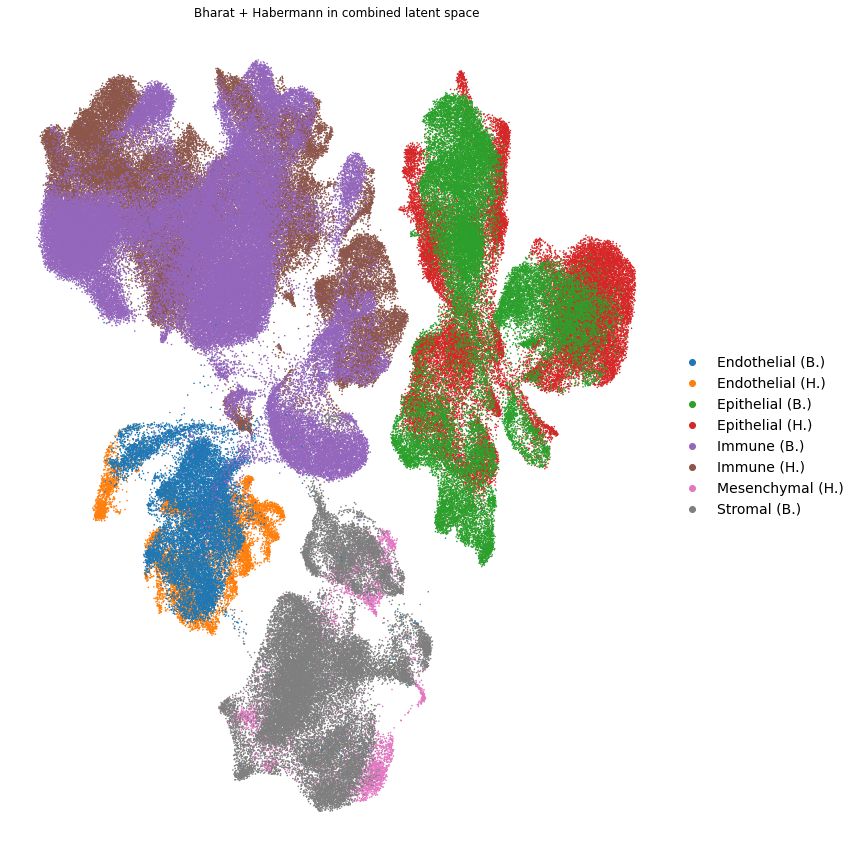

In [80]:
ax = sc.pl.umap(
    latent2, 
    color="population",
    frameon=False, 
    size=10, 
    title="Bharat + Habermann in combined latent space",
    legend_fontsize=14,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()
ax.figure.savefig("01lineage-combined.pdf")

### Cell types only for Habermann

Trying to set attribute `.uns` of view, copying.


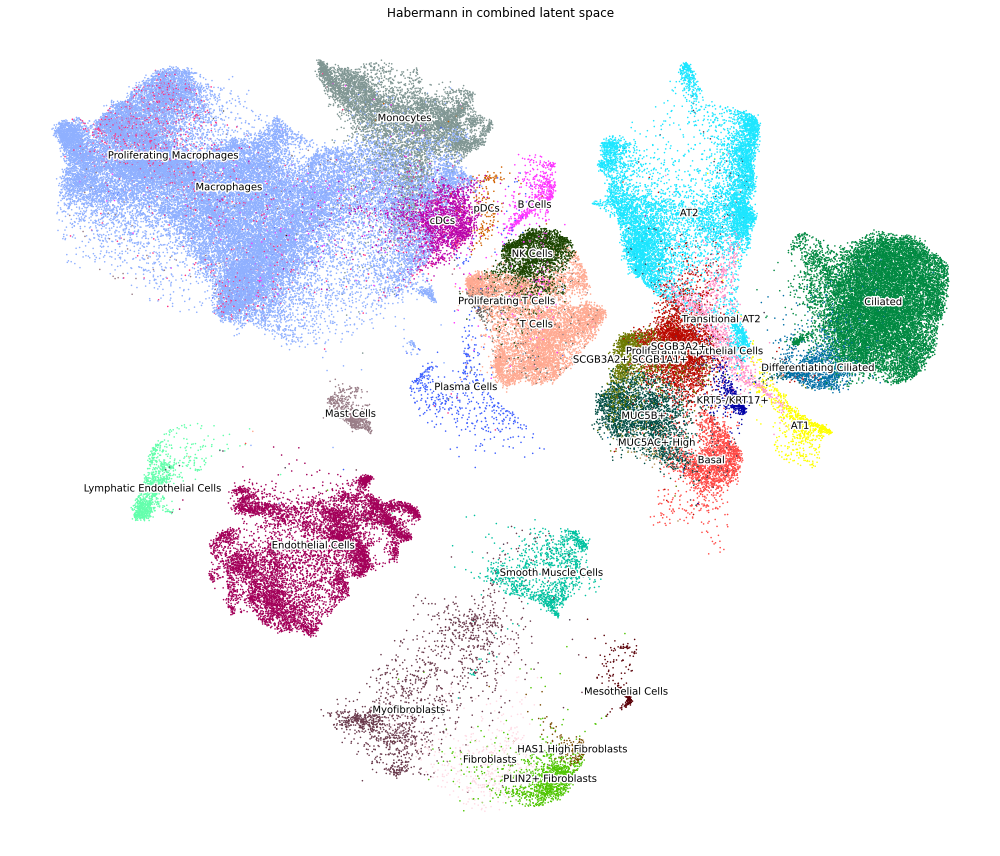

In [57]:
ax = sc.pl.umap(
    latent2[adata.obs_names, :], 
    color="celltype",
    frameon=False, 
    legend_loc="on data", 
    size=10, 
    title="Habermann in combined latent space",
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()
ax.figure.savefig("01celltypes-habermann.pdf")

### Cell types only for COVID-TX

Trying to set attribute `.uns` of view, copying.


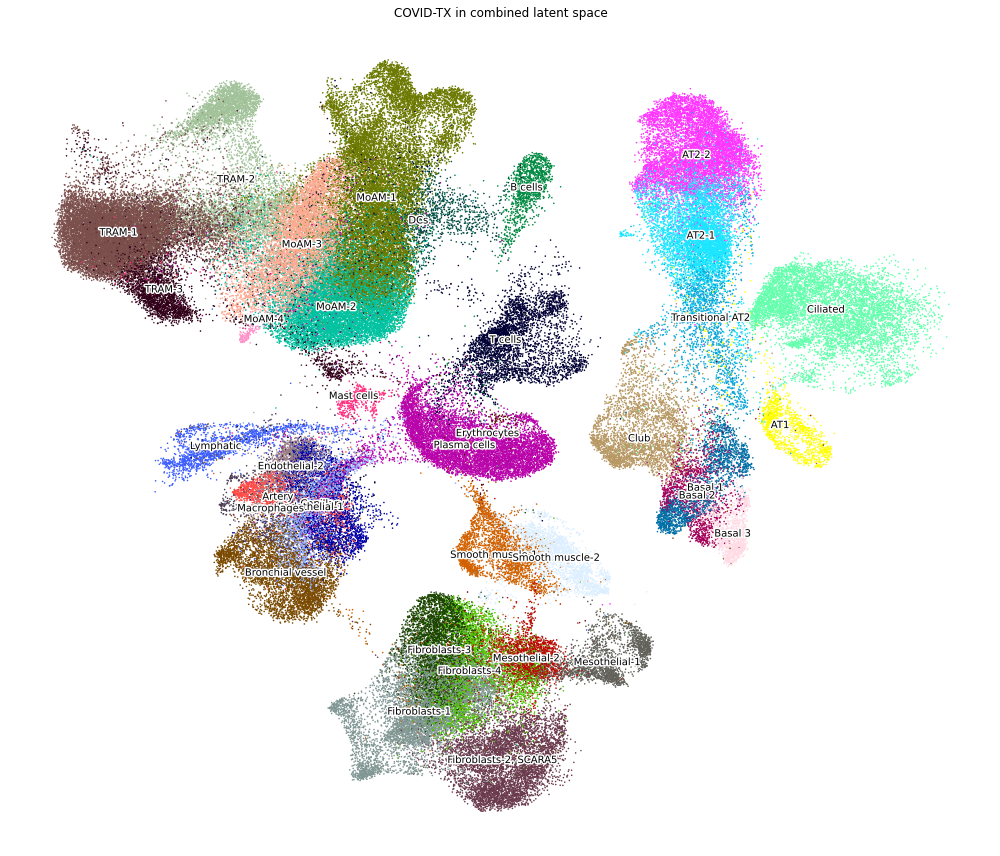

In [58]:
ax = sc.pl.umap(
    latent2[query.obs_names, :], 
    color="cluster",
    frameon=False, 
    legend_loc="on data", 
    size=10, 
    title="COVID-TX in combined latent space",
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()
ax.figure.savefig("01celltypes-covid-tx.pdf")

In [15]:
latent2.obs.Diagnosis = latent2.obs.Diagnosis.astype("str")
latent2.obs.loc[latent2.obs["COVID-19"] == "True", "Diagnosis"] = "COVID-19"
latent2.obs.loc[latent2.obs["COVID-19"] == "False", "Diagnosis"] = "Control (B.)"
latent2.obs.loc[latent2.obs.Diagnosis.isin(["ILD", "NSIP", "cHP", "Sarcoidosis"]), "Diagnosis"] = "Other PF"
latent2.obs.Diagnosis.replace({"Control": "Control (H.)"}, inplace=True)
latent2.obs.Diagnosis = latent2.obs.Diagnosis.astype("category")
latent2.obs.Diagnosis = latent2.obs.Diagnosis.cat.reorder_categories(
    ["Control (H.)", "Control (B.)", "COVID-19", "IPF", "Other PF"]
)

In [16]:
latent2.obs.Diagnosis = latent2.obs.Diagnosis.cat.remove_unused_categories()

### Merged diagnosis

In [24]:
cat_palette = list(mpl.cm.tab10.colors)
cat_palette[0], cat_palette[2] = cat_palette[2], cat_palette[0]
cat_palette[2], cat_palette[3] = cat_palette[3], cat_palette[2]

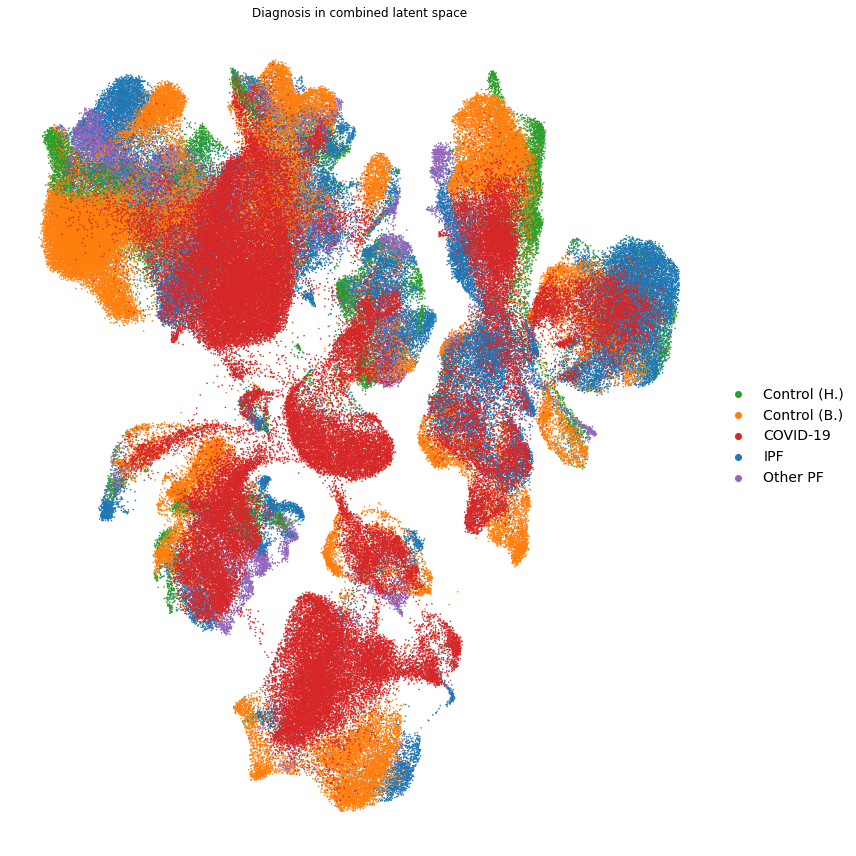

In [25]:
ax = sc.pl.umap(
    latent2, 
    color="Diagnosis",
    frameon=False, 
    size=10, 
    palette=cat_palette,
    title="Diagnosis in combined latent space",
    legend_fontsize=14,
    legend_fontoutline=3,
    legend_fontweight="normal",
    show=False
)
ax.figure.tight_layout()
ax.figure.savefig("01diagnosis-combined.pdf")

## Save the combined object for futher analysis

Save latent-space combined object

In [66]:
latent2.write_h5ad("../data/03ipf_projection/01latent2.h5ad")

Prepare combined object with all genes

In [16]:
query_raw = sc.read_h5ad("../data/02dataset/20global.h5ad")

In [17]:
query_raw = query_raw.raw.to_adata()

In [18]:
query_raw.obs["Study"] = "Bharat_et_al_2020"
query_raw.obs.Study = query_raw.obs.Study.astype("category")

In [19]:
both_full = sc.concat([ds, query_raw])

In [20]:
both_full.shape

(269809, 19202)

In [29]:
both_full.obs = latent2.obs.copy()

In [22]:
both_full.obsm["X_umap"] = latent2.obsm["X_umap"]

In [27]:
both_full

AnnData object with n_obs × n_vars = 269809 × 19202
    obs: 'orig.ident', 'Study', 'nCount_RNA', 'nFeature_RNA', 'Diagnosis', 'Sample_Name', 'Sample_Source', 'Status', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'population', 'celltype', 'n_genes', 'Day', 'Lung', 'Patient', 'Population', 'Replicate', 'Sample_num', 'Source', 'Type', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'Tissue_type', 'COVID-19', 'lineage', 'cluster'
    obsm: 'X_umap'

Straighten metadata

In [30]:
both_full.obs.celltype = both_full.obs.celltype.astype("str")
both_full.obs.loc[both_full.obs.celltype == "nan", "celltype"] = both_full.obs.cluster.loc[both_full.obs.celltype == "nan"]
both_full.obs.celltype = both_full.obs.celltype.str.replace("Cells", "cells")
both_full.obs.celltype = both_full.obs.celltype.astype("category")

In [31]:
both_full.obs.loc[both_full.obs.nCount_RNA == "nan", "nCount_RNA"] = np.nan
both_full.obs.nCount_RNA = both_full.obs.nCount_RNA.astype(float).astype("Int32")

In [32]:
both_full.obs.loc[both_full.obs.nCount_RNA.isna(), "nCount_RNA"] = both_full.obs.total_counts.loc[both_full.obs.nCount_RNA.isna()].astype(float)

In [33]:
both_full.obs.nCount_RNA = both_full.obs.nCount_RNA.astype(int)

In [34]:
both_full.obs.loc[both_full.obs.nFeature_RNA == "nan", "nFeature_RNA"] = np.nan
both_full.obs.nFeature_RNA = both_full.obs.nFeature_RNA.astype(float).astype("Int32")
both_full.obs.loc[both_full.obs.nFeature_RNA.isna(), "nFeature_RNA"] = both_full.obs.n_genes_by_counts.loc[both_full.obs.nFeature_RNA.isna()].astype(float)
both_full.obs.nFeature_RNA = both_full.obs.nFeature_RNA.astype(int)

In [35]:
both_full.obs.loc[both_full.obs["percent.mt"] == "nan", "percent.mt"] = np.nan
both_full.obs["percent.mt"] = both_full.obs["percent.mt"].astype(float)
both_full.obs.loc[both_full.obs["percent.mt"].isna(), "percent.mt"] = both_full.obs.pct_counts_mito.loc[both_full.obs["percent.mt"].isna()].astype(float)

In [36]:
both_full.obs["Tissue Type"] = both_full.obs["Tissue Type"].astype("str")
both_full.obs.loc[both_full.obs["Tissue Type"] == "nan", "Tissue Type"] = "Biopsy"
both_full.obs["Tissue Type"] = both_full.obs["Tissue Type"].astype("category")

In [40]:
both_full.obs.Sample_Name.value_counts()

Case 1     38486
Donor 2    36711
PMB 2      27648
Donor 1    26722
PMB 1      25846
VUILD59    15142
VUILD60     8463
VUILD61     8408
VUHD67      7612
VUILD58     6785
TILD015     6402
VUHD68      5815
VUILD62     5513
TILD028     4393
TILD019     4006
THD0005     3494
TILD006     3313
VUILD65     3190
TILD030     3082
VUHD66      2802
VUILD55     2749
THD0002     2647
VUHD65      2552
THD0001     2218
VUHD071     2195
TILD001     2128
VUILD63     2124
VUILD57     1809
TILD010     1584
VUHD70      1509
VUILD64     1419
VUILD53     1116
VUHD69       800
VUILD54      750
VUILD48      376
Name: Sample_Name, dtype: int64

In [39]:
both_full.obs.Sample_Name = both_full.obs.Sample_Name.astype("str")
both_full.obs.loc[both_full.obs.Sample_Name == "nan", "Sample_Name"] = both_full.obs["Sample Name"].loc[both_full.obs.Sample_Name == "nan"]
both_full.obs.Sample_Name = both_full.obs.Sample_Name.astype("category")

In [41]:
both_full.obs.Sample_Source = both_full.obs.Sample_Source.astype("str")
both_full.obs.loc[both_full.obs.Sample_Source == "nan", "Sample_Source"] = "NU"
both_full.obs.Sample_Source = both_full.obs.Sample_Source.astype("category")

In [42]:
both_full.obs.loc[both_full.obs["COVID-19"] == "True", "Status"] = "Disease"
both_full.obs.loc[both_full.obs["COVID-19"] == "False", "Status"] = "Control"

In [43]:
both_full.obs.Diagnosis = latent2.obs.Diagnosis.copy()

In [44]:
both_full.obs.Status.value_counts()

Disease    174732
Control     95077
nan             0
Name: Status, dtype: int64

In [46]:
both_full.obs.drop([
    'nCount_SCT', 'nFeature_SCT', 'seurat_clusters', 'n_genes', 'Day', 'Lung', 'Patient', 
    'Population', 'Replicate', 'Sample_num', 'Source', 'Type', 'n_genes_by_counts', 'total_counts', 
    'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo',
    'lineage', 'cluster'
], axis=1, inplace=True)

In [47]:
both_full.write_h5ad("../data/03ipf_projection/01combined.h5ad")